# Accelerating Portfolio Optimization

## Context

It is assumed it is an inherently sequential process but it can be accelerated by GPUs. Portfolio optimzation has existed for years and this will focus on the Markowitz risk-return method. 

Harry Markowitz was the first to formalise the risk-return trade-off approach and has since been modified. You look at the assets, you look at their covariance and then you solve it in one step. Then Marco Lopez de Prado presented the idea of clustering the assets which are more correlated then spread the risk among clusters in a hierarchal fashion. 

Reinforcement learning can also be used to dynamically adjust portfolios based on market signals. 

## Where does this fall in the Trading context?

Optimization appears at many parts of the trading, but the portfolio optimization appears at the execution stage. 
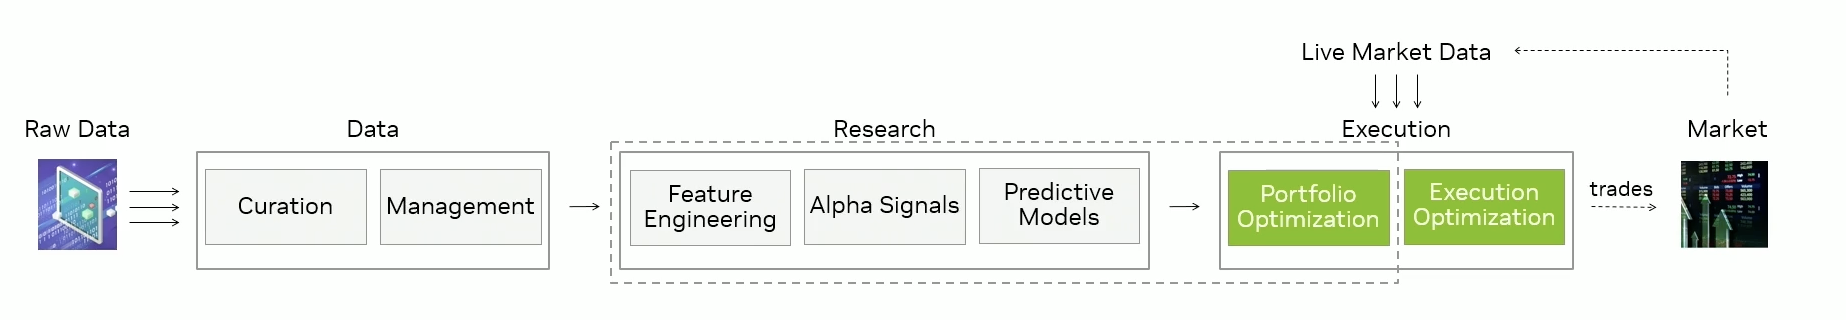

## Where does this fall in the Performance Context?

The data from the portfolio optimization can be passed into the simulated execution or some form of simulation. 

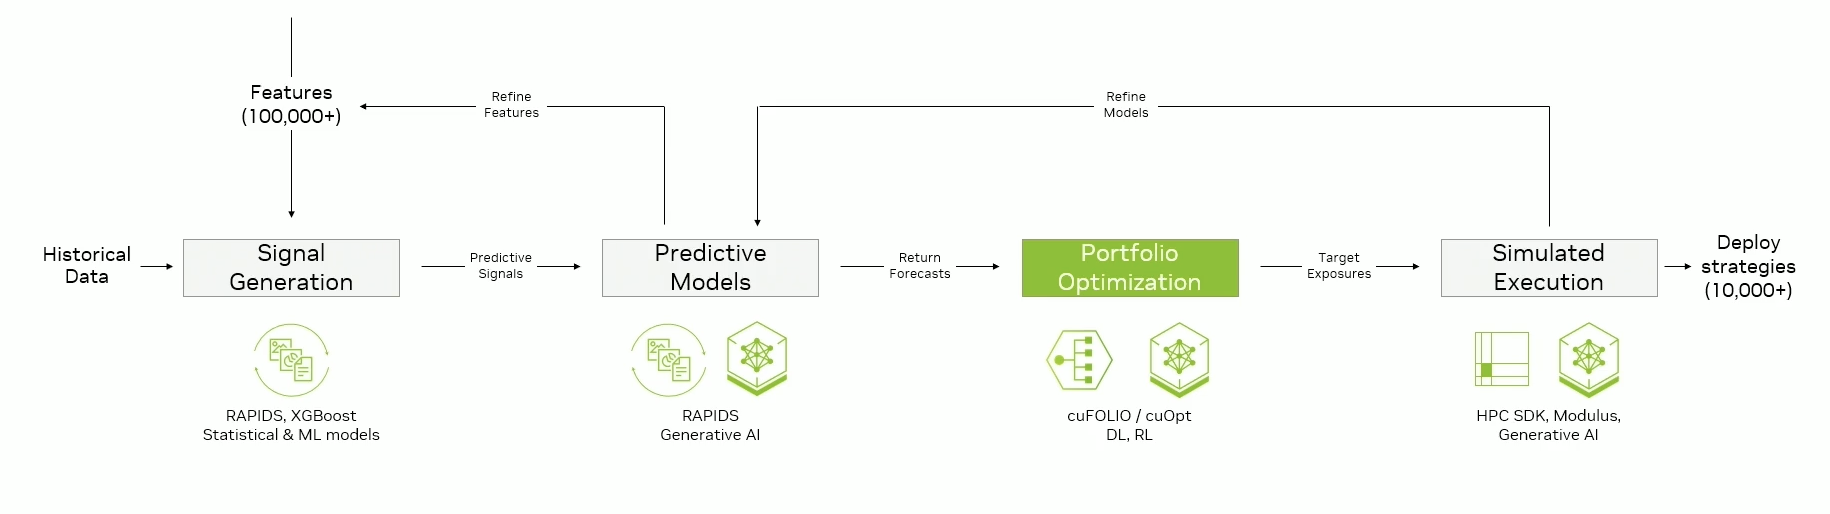

## What are the objectives of portfolio optimization?

*  **Maximising the alpha for a given level of volatility** - alpha could be value model or DDM model, for a quant, it could be a factor model, but ultimately you are trying to maximise your projected returns for some risk budget. Most good managers are good bottom-up stock selectors, with good fundamental understanding but not always good top-down. You also need to account for constraints in the solution space

* **Minimising unintended risk**- these include concepts like risk style, tracking errors and timing of factors. It is key to look at the whole risk budget

* **Hedging strategies** - for example, you have a fixed-income portfolio and you have high yield credit exposure and you're trying to minimize that, you may want to optimize some portfolio to reduce the overall exposure to credit spread and ultimately you want to hedge to reduce tracking error and volatility; you also want to ensure that hedge aligns with your securities. You want to minimize tracking error and minimize the drift, which is the tendency of portfolios to deviate over time due to structural bias. Cointegration is a key part of it, you want the related tracking baskets to have a relationship that is mean-reverting

* **Long-only vs Long/Short portfolio** - the concepts are similar but you must be considerate of the real world constraints

## What data and technologies are used?

**Data** - these are all things used to guide us in terms of the where the market is positions

* Prices
* Fundamentals
* Deriavtives
* Yield curves
* Credit Spreads - these are windows into risk in the fixed-income market through capital structure arbitage
* Macroeconomic data 
* Speculative positioning data

**Analytics and modelling tools** 

* Risk Models - they estimate volatility, estimating covariance etc. 
* Factor Models
* Optimization frameworks - are you using a CVar
* Integration - this ensures risk, execution and portfolio managment tools work seamlessly

## How do we optimize each asset class?

* **Equities** - these are more normally distributed with larger skewness or kurtosis, traditional mean-variance approach works but when accounting for derivatives, consider CVaR 
* **Commodities** - this is event driven, you can't use the mean-variance model, driven by geopolitical events, doesn't follow normal distribution

* **Fixed income** - non-linear with sudden regime shifts, you need a hybrid approach due to sudden shift which are best modelled by conditional VaR

* **Currencies** - these are macro, event driven, use a hybrid approach


## What are practical portfolio considerations?

* Constrain solutions to practical ranges - make it real world, such as concentration or drift
* Emphasise robustness over overfitting - you need guard rails
* Regular stress testing across market regimes - what happens if rates move up or volatility moves up, its an iterative process
* Dynamic model refinement to reflect evolving markets - make them more dynamic


## What are the Mathematical foundations of portfolio optimization?


At the core of problem is the trade-off between risk and return. Return is how much money you can make for your investments. However, there are a range of ways to measure risk, including:

* Translation invariance - adding additional cash reduces risk

* Positive homogeneity - risk scales with portfolio

* Monotonicity - higher returns are less risky

* Sub-additivity - diversification does not increase risk, introduced by Markowitz

There are key metrics used to quantify risk including:

* Variance - it captures the fluctuation in the underlying return, it is not coherent however, as it cannot identify good risk

* Value-at-Risk (VaR) - this quantifies just the left side of the distribution, the worse case scenario, widely used in the US, look at quantile confidence, doesn't satisfy the sub-additivity property

* Conditional Value-at-Risk - instead of looking at a point estimate of the worse case loss, you're looking at the average of the worse case, conditional expectation of loss

### Optimization of CVaR

If you want to tackle the problem, it must be reformulated to this equation. You can convert it into linear programming by using the mathematics trick of converting a maximum function to linear constraints. 

$$CVaR_\alpha \bold{w} = min \{t + \frac{1}{1-\alpha}\sum_{\omega \in \Omega}p(\omega) max \{loss(\bold{w},\omega) - \it{t}, 0\}\} $$

$$loss(\omega, \bold{w}) = - R^T(\omega)\bold{w}$$

$$Minimize: t + \frac{1}{1-\alpha}p^{T}u$$


There are real constraints that must be considered, including: 

* Concentration limit on single assets - you don't want to invest too much in one asset
* Amount invested in risk-free assets - how much cash you have
* Leverage constraints - reduce overall exposure
* Investment budget - how much you can invest
* Turnover from existing portfolio - it can't realistically deviate too much from your existing portfolio

This can all be formulated into a linear program, you may want to limit the assets too using the binary variable $b_i$, so it becomes a **mixed integer linear program**, these are the easiest to solve in optimization. They can be solved on a CPU using a simplex or interior point method but they can be solved faster using a GPU using CuOpt. 

## How can this be accelerated on a GPU?

Linear programming has been around for years but more recently, we got the *Primal-Dual Hybrid Gradient* which can be used to solve a LP in the form:

$$ minimize\ {c^T} x$$
$$ subject\ to \ Ax = b:y , l\leq x\leq u$$

At each stage, there is an iterate, but broadly it has an issue with convergence, so the approach was extended to *Primal-Dual Linear Programming*, which improves the convergence issue of PDHG and therefore a fraction of the problems are solved within given time. So if you fix a test set, it can solve all of the problems.
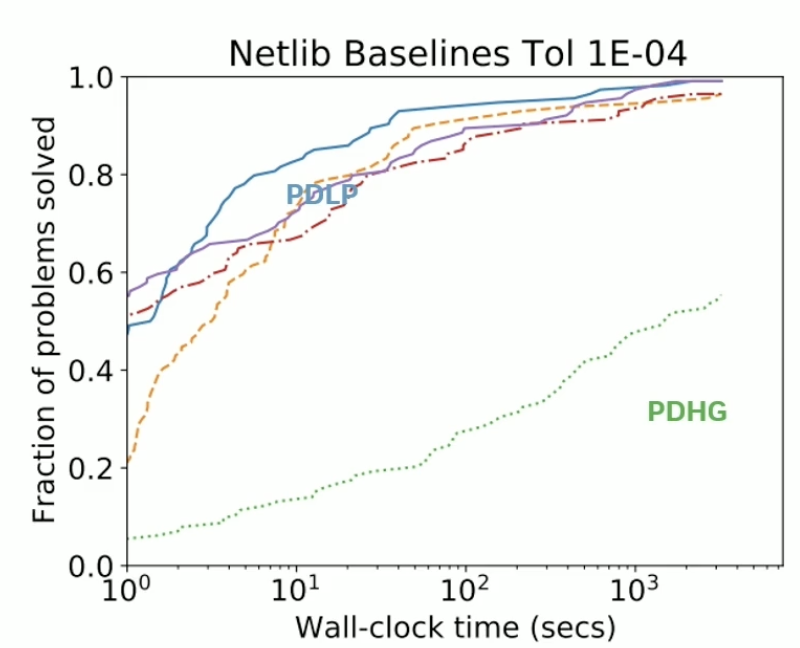


cuOpt has a GPU-based PDLP, most of the time is spent computing two sparse matrix-vector multiplies:
$$A^T y, Ax$$